In [1]:
import os
import sys
import time
import pickle
from collections import defaultdict
from functools import partial
import torch
from torchviz import make_dot

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

from safe_control_gym.lyapunov.utilities import *
from safe_control_gym.lyapunov.lyapunov import LyapunovNN, Lyapunov, QuadraticFunction, GridWorld_pendulum

# set random seed for reproducibility
seed = 2
torch.manual_seed(seed)
np.random.seed(seed)

np.set_printoptions(threshold=sys.maxsize) # np print full array
# torch.autograd.set_detect_anomaly(True)

class Options(object):
    def __init__(self, **kwargs):
        super(Options, self).__init__()
        self.__dict__.update(kwargs)

OPTIONS = Options(np_dtype              = np.float32,
                  torch_dtype           = torch.float32,
                  eps                   = 1e-8,                            # numerical tolerance
                  saturate              = True,                            # apply saturation constraints to the control input
                  use_zero_threshold    = True,                            # assume the discretization is infinitely fine (i.e., tau = 0)
                  pre_train             = True,                            # pre-train the neural network to match a given candidate in a supervised approach
                  dpi                   = 150,
                  num_cores             = 4,
                  num_sockets           = 1,
                #   tf_checkpoint_path    = "./tmp/lyapunov_function_learning.ckpt"
                )

# detect torch device
# myDevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myDevice = torch.device("cpu")
# if torch.cuda.is_available():
#     myDevice = torch.device("cuda:0")
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

/home/tumeilsy-mo-10/anaconda3/envs/safe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants
dt = 0.01   # sampling time
g = 9.81    # gravity

# True system parameters
m = 0.15    # pendulum mass
L = 0.5     # pole length
b = 0.1     # rotational friction

# State and action normalizers
theta_max = np.deg2rad(180)                     # angular position [rad]
omega_max = np.deg2rad(360)                     # angular velocity [rad/s]
# u_max     = g * m * L * np.sin(np.deg2rad(60))  # torque [N.m], control action
u_max = 0.5

state_norm = (theta_max, omega_max)
action_norm = (u_max,)

# Dimensions and domains
state_dim     = 2
action_dim    = 1
state_limits  = np.array([[-1., 1.]] * state_dim)
action_limits = np.array([[-1., 1.]] * action_dim)

In [3]:
# Initialize system class and its linearization
pendulum = InvertedPendulum(m, L, b, dt, [state_norm, action_norm])
A, B = pendulum.linearize()
# print("A\n ", A)
# print("B\n ", B)
# dynamics = pendulum.__call__
dynamics = pendulum.__call__

# # test dynamics with state [0.5, 0] and action [0.5]
# x = torch.tensor([0.5, 0.], dtype=OPTIONS.torch_dtype)
# u = torch.tensor([-0.5], dtype=OPTIONS.torch_dtype)
# x = np.array([0.5, 0.])
# u = np.array([-0.5])
# print("x: ", x)
# print("u: ", u)
# state_action = np.concatenate([x, u])
# state_action = torch.cat([x, u])
# print("state_action: ", state_action)

# x_next = dynamics(state_action)
# print("x_next: ", x_next)
# assert x_next.shape == x.shape
# print("Dynamics shape test passed!")

In [4]:
state_constraints = np.array([[-theta_max, theta_max], [-omega_max, omega_max]])

print('state_constraints: ', state_constraints)
num_states = 100

grid_limits = np.array([[-1., 1.], ] * state_dim)
# state_discretization = gridding(state_dim, state_constraints=None, num_states = 100)
state_discretization = GridWorld_pendulum(grid_limits, num_states)
# state_discretization = gridding(state_dim, state_constraints, num_states = 100)
print('state_discretization.all_points.shape: ', state_discretization.all_points.shape)

state_constraints:  [[-3.14159265  3.14159265]
 [-6.28318531  6.28318531]]
state_discretization.all_points.shape:  (10000, 2)


In [5]:
# Discretization constant
if OPTIONS.use_zero_threshold:
    tau = 0.0
else:
    tau = np.sum(state_discretization.unit_maxes) / 2

print('Grid size: {}'.format(state_discretization.nindex))
print('Discretization constant (tau): {}'.format(tau))

# Set initial safe set as a ball around the origin (in normalized coordinates)
cutoff_radius    = 0.1
initial_safe_set = np.linalg.norm(state_discretization.all_points, ord=2, axis=1) <= cutoff_radius
print('state_discretization.all_points.shape: ', state_discretization.all_points.shape)
print('initial_safe_set.sum(): ', initial_safe_set.shape)

Grid size: 10000
Discretization constant (tau): 0.0
state_discretization.all_points.shape:  (10000, 2)
initial_safe_set.sum():  (10000,)


In [7]:
Q = np.identity(state_dim).astype(OPTIONS.np_dtype)     # state cost matrix
Q = np.diag([5, 1])
R = 1* np.identity(action_dim).astype(OPTIONS.np_dtype)    # action cost matrix
# K, P_lqr = safe_learning.utilities.dlqr(A, B, Q, R)
K, P_lqr = dlqr(A, B, Q, R) 
# print('K',K)

policy = lambda x: -K @ x
if OPTIONS.saturate:
    # policy = lambda x: np.clip(-K @ x, -u_max, u_max)
    policy = lambda x: np.clip(-K @ x, -1, 1)

cl_dynamics = lambda x: dynamics(np.concatenate([x, policy(x)]))

# test the closed-loop dynamics with state [0.5, 0]
x = np.array([0.20, 0.])
for i in range(100):
    x = cl_dynamics(x)
    # print("x: ", x)
    

In [8]:
L_pol = lambda x: np.linalg.norm(-K, 1)

L_dyn = lambda x: np.linalg.norm(A, 1) + np.linalg.norm(B, 1) * L_pol(x)

In [11]:
lyapunov_function = QuadraticFunction(P_lqr)

# Approximate local Lipschitz constants with gradients
# grad_lyapunov_function = lambda x: 2 * P_lqr @ x
grad_lyapunov_function = lambda x: 2 * torch.tensor(P_lqr, dtype=torch.float32) @ x
# L_v = lambda x: tf.norm(grad_lyapunov_function(x), ord=1, axis=1, keepdims=True)
L_v = lambda x: torch.norm(grad_lyapunov_function(x), p=1, dim=-1, keepdim=True)

# Initialize Lyapunov class
lyapunov_lqr = Lyapunov(state_discretization, lyapunov_function, cl_dynamics, L_dyn, L_v, tau, policy, initial_safe_set)
# print the first 10 states in the safe set
lyapunov_lqr.discretization.all_points[1:10]
# print('lyaupunov_lqr.discretization.all_points[1:10]\n', lyapunov_lqr.discretization.all_points[1:10])
lyapunov_lqr.update_values()
lyapunov_lqr.update_safe_set()
# print('lyapunov_lqr.safe_set\n', lyapunov_lqr.safe_set[1:10])
# print('lyapunov_lqr.values\n', lyapunov_lqr.values[1:10])
# print('lyapunov_lqr.c_max\n', lyapunov_lqr.c_max)
print('lyapunov_lqr.safe_set.sum()\n', lyapunov_lqr.safe_set.sum())

lyapunov_lqr.safe_set.sum()
 2006


In [36]:
horizon = 500
tol = 0.1
# roa, trajectories = compute_roa_pendulum(lyapunov_lqr.discretization, cl_dynamics, horizon, tol, no_traj=False)
compute_new_roa = False
# compute_new_roa = True

# get the current path of this jupyter notebook
script_dir = os.getcwd()
roa_file_name = 'roa_pendulum_{}.npy'.format(num_states)
traj_file_name = 'traj_pendulum_{}.npy'.format(num_states)
# append the file name to the current path
roa_file_name = os.path.join(script_dir, roa_file_name)
traj_file_name = os.path.join(script_dir, traj_file_name)
if not compute_new_roa:
    # load the pre-saved ROA to avoid re-computation
    roa = np.load(roa_file_name)
    trajectories = np.load(traj_file_name)
else:
    roa, trajectories = compute_roa_pendulum(lyapunov_lqr.discretization, cl_dynamics, horizon, tol, no_traj=False)
    np.save(roa_file_name, roa)
    np.save(traj_file_name, trajectories)
    # exit()

print('True ROA size:{}\n'.format(int(roa.sum())))
print('')

True ROA size:2518




In [16]:
#########################################################################
# train the parameteric Lyapunov candidate in order to expand the verifiable
# safe set toward the brute-force safe set

# grid              = lyapunov_lqr.discretization
grid              = lyapunov_lqr.discretization
# c_max             = [lyapunov_lqr.c_max, ]
# safe_set_fraction = [lyapunov_lqr.safe_set.sum() / grid.nindex, ]
# print('safe_set_fraction', safe_set_fraction)

grid.all_points.shape

(10000, 2)

sampled_data.shape:  (2, 500)


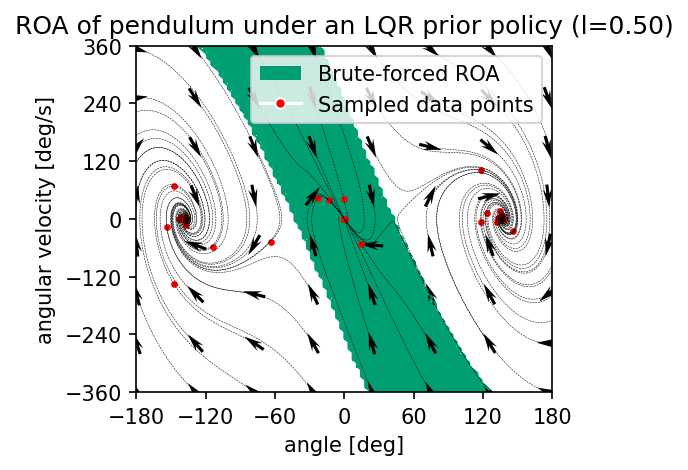

In [177]:
################################ plotting ################################
fig = plt.figure(figsize=(8, 3), dpi=OPTIONS.dpi, frameon=False)
fig.subplots_adjust(wspace=0.35)
plot_limits = np.column_stack((- np.rad2deg([theta_max, omega_max]), np.rad2deg([theta_max, omega_max])))

# ax = plt.subplot(121)
ax = plt.subplot(111)
alpha = 1
colors = [None] * 4
colors[0] = (0, 158/255, 115/255)       # ROA - bluish-green
colors[1] = (230/255, 159/255, 0)       # NN  - orange
colors[2] = (0, 114/255, 178/255)       # LQR - blue
colors[3] = (240/255, 228/255, 66/255)  # SOS - yellow

# True ROA
z = roa.reshape(grid.num_points)
# print(z.shape)
# print(z)
ax.contour(z.T, origin='lower', extent=plot_limits.ravel(), colors=(colors[0],), linewidths=1)
ax.imshow(z.T, origin='lower', extent=plot_limits.ravel(), cmap=binary_cmap(colors[0]), alpha=alpha)



# Plot some trajectories
N_traj = 7
skip = int(grid.num_points[0] / N_traj)
sub_idx = np.arange(grid.nindex).reshape(grid.num_points)
sub_idx = sub_idx[::skip, ::skip].ravel()
sub_trajectories = trajectories[sub_idx, :, :]
sub_states = grid.all_points[sub_idx]
for n in range(sub_trajectories.shape[0]):
    x = sub_trajectories[n, 0, :] * np.rad2deg(theta_max)
    y = sub_trajectories[n, 1, :] * np.rad2deg(omega_max)
    ax.plot(x, y, 'k--', linewidth=0.25)
sub_states = grid.all_points[sub_idx]
dx_dt = np.zeros_like(sub_states)
for state_idx in range(sub_states.shape[0]):
    dx_dt[state_idx, :] = (cl_dynamics(sub_states[state_idx, :]) - sub_states[state_idx, :])/dt

# dx_dt = (tf_future_states.eval({tf_states: sub_states}) - sub_states) / dt
dx_dt = dx_dt / np.linalg.norm(dx_dt, ord=2, axis=1, keepdims=True)
ax.quiver(sub_states[:, 0] * np.rad2deg(theta_max), sub_states[:, 1] * np.rad2deg(omega_max), dx_dt[:, 0], dx_dt[:, 1], 
          scale=None, pivot='mid', headwidth=3, headlength=6, color='k')

# get some points on the trajectory
# and plot them
num_samples = 50
idx = np.random.choice(sub_trajectories.shape[0], num_samples, replace=False)
sampled_trajectories = sub_trajectories[idx]
# in each sub-trajectory, sample 10 points
num_points = 500
sampled_data = np.zeros((2, num_points))
idx = np.random.choice(horizon, num_points, replace=False)
for i in range(num_samples):
    sampled_points = sampled_trajectories[i, :, idx[i]]
    sampled_data[:, i] = sampled_points.T
    # print('sampled_points.shape: ', sampled_points.shape)
print('sampled_data.shape: ', sampled_data.shape)
ax.scatter(sampled_data[0] * np.rad2deg(theta_max), sampled_data[1] * np.rad2deg(omega_max), c='r', s=5)



ax.set_title('ROA of pendulum under an LQR prior policy (l={:.2f})'.format(L))
ax.set_aspect(theta_max / omega_max / 1.2)
ax.set_xlim(plot_limits[0])
ax.set_ylim(plot_limits[1])
ax.set_xlabel(r'angle [deg]')
ax.set_ylabel(r'angular velocity [deg/s]')
ax.xaxis.set_ticks(np.arange(-180, 181, 60))
ax.yaxis.set_ticks(np.arange(-360, 361, 120))

proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in colors]    
legend = ax.legend(proxy, [r'Brute-forced ROA'], loc='upper right')
legend.get_frame().set_alpha(1.)

# add the legend for sampled points (as red dots)
proxy = [plt.Rectangle((0,0), 1, 1, fc= colors[0]),
         plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=5)]
legend = ax.legend(proxy, [r'Brute-forced ROA', 'Sampled data points'], loc='upper right')


plt.show()

sub_trajectories.shape:  (25, 2, 500)
sampled_traj.shape:  (10, 2, 500)
sampled_data.shape:  (2, 10)
sampled_points.shape:  (2,)
sampled_points.shape:  (2,)
sampled_points.shape:  (2,)
sampled_points.shape:  (2,)
sampled_points.shape:  (2,)
sampled_points.shape:  (2,)
sampled_points.shape:  (2,)
sampled_points.shape:  (2,)
sampled_points.shape:  (2,)
sampled_points.shape:  (2,)
sampled_data.shape:  (2, 10)
sampled_data:  [[-7.63159435e-01 -5.82475852e-04  4.79451439e-06 -7.68050620e-01
   7.68676772e-01  7.55014307e-01 -7.66240186e-01 -7.61408416e-01
   1.55525134e-09  9.14529877e-02]
 [-8.69445055e-03  1.00739029e-03 -8.39212633e-06  3.13848084e-02
  -6.40337916e-04  2.28273815e-01  3.02011099e-02  3.70682601e-03
  -2.72230941e-09 -2.53088807e-01]]


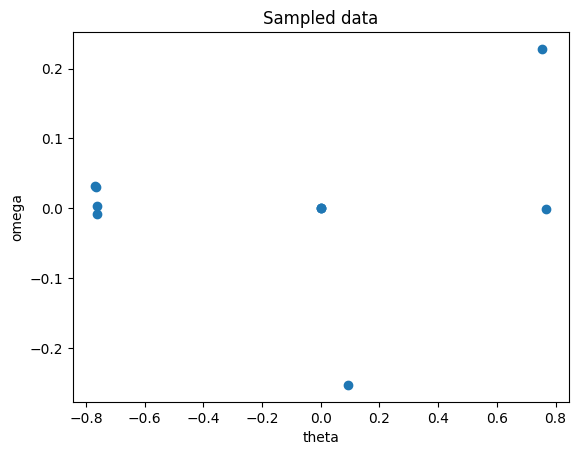